In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns 
import matplotlib.pyplot as plt
import EpiClockNBL.src.util as pc_util
pc_consts = pc_util.consts
import EpiClockNBL.Select_fCpGs.util as local_util
import EpiClockNBL.src.maxima as maxima

In [2]:
# Output directories

proj_dir = os.path.join(pc_consts['official_indir'], 'Heinrich')

figure_outdir = 'figures'
output_dir = 'outputs'
outfile_dir = os.path.join(output_dir, 'outfiles')
outdir = proj_dir

os.makedirs(figure_outdir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(outfile_dir, exist_ok=True)
os.makedirs(outdir, exist_ok=True)

In [3]:

###############################
##### IMPORT/PROCESS DATA #####
###############################

# Import beta values of unbiased sites
beta_values_unbiased_sites = pd.read_table(
    os.path.join(proj_dir, 'beta_values_unbiased_sites.txt'),
    index_col=0
)
balanced_CpGs = beta_values_unbiased_sites.index.values
print(f'Starting with {balanced_CpGs.shape[0]} balanced sites')

# Must place beta values in this dictionary object for function compatability
data = {'tumor':{'beta_values_SELECTION':beta_values_unbiased_sites}}

# Ideally, 1000 Clock sites selected
# We dont want to select more than half the number of unbiased sites (n)
# If n/2 < 1000, only pick n/2 sites
target_n = min(1000, int(balanced_CpGs.shape[0] / 2))
print(f'Picking {target_n} target sites')


########################
##### SELECT SITES #####
########################

# Fill missing values with mean of that site across tumors
km_beta_values = beta_values_unbiased_sites.apply(lambda x:x.fillna(x.mean()), axis=1)

# Determine clustering weights
# See local_util for details
clustering_weights_list = [local_util.clusteringWeights(km_beta_values, random_state=0) for i in range(50)]
clustering_weights_ser = pd.concat(clustering_weights_list, axis=1).mean(axis=1)

# Calculate inter-tumor stdevs of sites
# Make array of unbiased sites that are not in the lowest 25%
balanced_beta_stdevs = beta_values_unbiased_sites.std(axis=1).dropna()
balanced_notStuck = balanced_beta_stdevs.index[balanced_beta_stdevs > np.quantile(balanced_beta_stdevs, 0.25)].values

# Only consider sites in balanced_notStuck
# Sort sites by clustering weights and select 1000 (or fewer) sites with the lowest weight
most_random_sites_nonIterNotStuck = clustering_weights_ser.loc[balanced_notStuck].sort_values().index[:target_n].values

# Calculate c_beta using Clock sites
c_beta = 1 - data['tumor']['beta_values_SELECTION'].loc[most_random_sites_nonIterNotStuck].std(axis=0)
n_samps = 36

########################
###### SAVE FILES ######
########################

# Reset variable name
Clock_CpGs = most_random_sites_nonIterNotStuck

## Save Clock CpG list
Clock_CpGs_filepath = os.path.join(output_dir, f'Heinrich_Clock_CpGs.txt')

# Save Clock sites, don't overwrite existing file
if os.path.exists(Clock_CpGs_filepath):
    existing_set = np.loadtxt(Clock_CpGs_filepath, dtype=str)
    assert np.all(np.sort(Clock_CpGs) == np.sort(existing_set))
    print('Current output matches existing file.')
else:
    np.savetxt(Clock_CpGs_filepath, Clock_CpGs, fmt='%s')

## Save c_beta values of final tumors
c_beta_final_samples = c_beta
c_beta_filepath = os.path.join(output_dir, f'Heinrich.c_beta.txt')

# Save c_beta values, don't overwrite existing file
if os.path.exists(c_beta_filepath):
    existing_c_beta = pd.read_table(c_beta_filepath, index_col=0, header=None).squeeze("columns")
    assert (c_beta_final_samples - existing_c_beta < 1e-6).all()
    print('Current output matches existing file.')
else:
    c_beta_final_samples.to_csv(c_beta_filepath, sep='\t', header=False)

# Save beta values of Clock sites
outfile_path = os.path.join(outdir, f'Heinrich.methyl.antiNonIterClustNotStuck_sites.tsv')
data['tumor']['beta_values_SELECTION'].loc[Clock_CpGs].to_csv(outfile_path, sep='\t')

Starting with 4112 balanced sites
Picking 1000 target sites


In [4]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4, random_state=None).fit(km_beta_values.T)

In [5]:
km.labels_

array([3, 2, 1, 3, 1, 0, 1, 1, 1, 1, 1, 3, 2, 3, 2, 1, 0, 1, 3, 3, 0, 1,
       2, 2, 0, 0, 2, 3, 1, 0, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 3, 3, 1, 0, 0, 0, 0, 3, 1, 1, 1, 2, 1, 3, 1, 3, 2, 2, 0,
       0, 0, 0, 1, 0, 0, 3, 1, 0, 1, 2, 1, 1, 1, 2, 0, 1, 2, 0, 0, 0, 3,
       0, 2, 0, 2, 1, 0, 2, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0], dtype=int32)

In [6]:
from sklearn.decomposition import PCA

In [7]:
tumors_transformed = PCA(2).fit_transform(km_beta_values.T)

<Axes: xlabel='x', ylabel='y'>

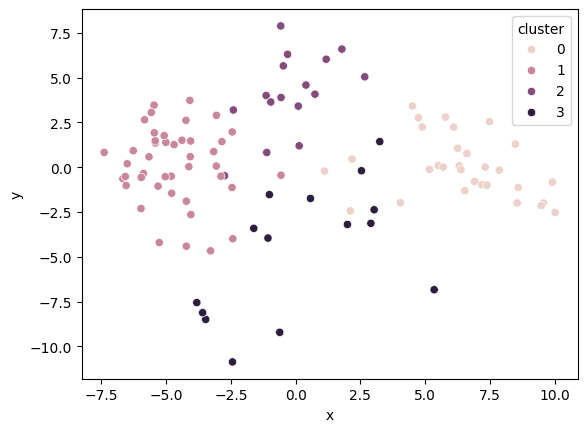

In [8]:
plot_data = pd.concat([pd.DataFrame(tumors_transformed, columns=['x', 'y']), pd.Series(km.labels_, name='cluster')], axis=1)
sns.scatterplot(data=plot_data, x='x', y='y', hue='cluster')

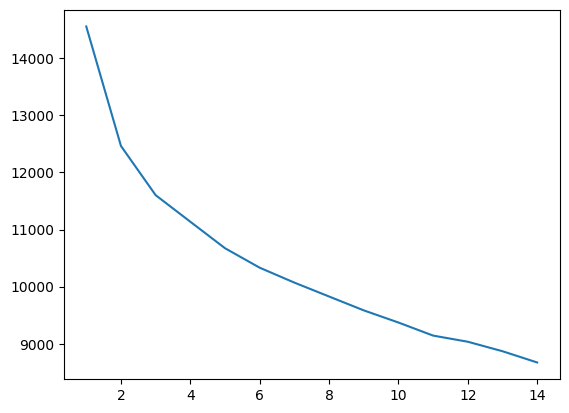

In [9]:
RSS_list = []
choices = list(range(1, 15))
for i in choices:
    inertia_list = [KMeans(n_clusters=i, random_state=None).fit(km_beta_values.T).inertia_ for j in range(20)]
    RSS_list.append(np.mean(inertia_list))

plt.plot(choices, RSS_list)

<Axes: xlabel='GSM1896914', ylabel='Count'>

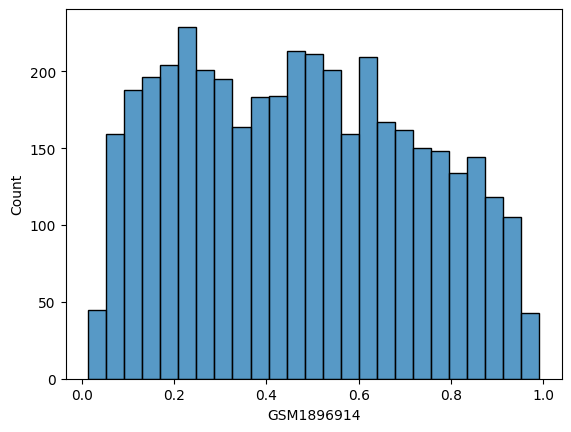

In [10]:

sns.histplot(beta_values_unbiased_sites['GSM1896914'], bins=25)